In [1]:
using ForwardDiff

In [2]:
using JLD2
using FileIO
using PyPlot
using Statistics
using StatsBase 
using Distributions
using LinearAlgebra
using HDF5

In [3]:
using IntervalSets
using Random, ArraysOfArrays
using ValueShapes
using Measurements

In [4]:
# using Revise
using BAT 

In [5]:
conv_mat = load("../data/experiment/dataset_2/m2/conv-matrix-upd-1.jld2")

conv_matrices = (
    cam_1 = conv_mat["cam_1"],
    cam_2 = conv_mat["cam_2"],
    cam_3 = conv_mat["cam_3"],
    cam_4 = conv_mat["cam_4"], 
) 

images = load("../data/experiment/dataset_2/m2/images-satur.jld2");
event_number = 440

# Large Charge: Ev_2_2 = 2, Ev_2_1 = 311, Ev_2_3 = 440

event = (
    cam_1 = images["cam_1"][event_number,:,:],
    cam_2 = images["cam_2"][event_number,:,:],
    cam_3 = images["cam_3"][event_number,:,:],
    cam_4 = images["cam_4"][event_number,:,:],
    population = images["charge"][event_number,:][1],
);


In [6]:
function likelihood_cam4(
        params::T, 
        image::Array{Float64,2},
        population::Float64,
        cam_ind::Int64;
        n_threads = Threads.nthreads()
    ) where {T <: NamedTuple}
   
    VT = typeof(params.tr_size[1])
    
    tot_loglik = zeros(VT, n_threads)    
    light_coefficient::Float64 = params.cam4_light_amp * 10^5
    
    δ_x::VT = params.cam4_psx * 10^-3
    δ_y::VT = params.cam4_psy * 10^-3
    
    μ_x::VT  = params.algmx[cam_ind] * δ_x
    μ_y::VT  = params.algmy[cam_ind] * δ_y
    
    σ_x::VT = sqrt.(params.tr_size[1]^2 + 10^-4*params.ang_spr[1]^2*(params.waist[1] - params.s_cam[cam_ind])^2) 
    σ_y::VT = sqrt.(params.tr_size[2]^2 + 10^-4*params.ang_spr[2]^2*(params.waist[1] - params.s_cam[cam_ind])^2) 

    
    σ_x = sqrt(σ_x^2 + (params.cam4_resx*δ_x).^2)
    σ_y = sqrt(σ_y^2 + (params.cam4_resy*δ_y).^2)
    
    
    Threads.@threads for t = 1:n_threads
        
        cum_log_lik = zero(VT)
        
        for pix_ind in CartesianIndices(image)[t:n_threads:length(image)] 
            
            if !isnan(image[pix_ind])
                
                x_edge::VT = pix_ind.I[1] * δ_x
                y_edge::VT = pix_ind.I[2] * δ_y
            
                pix_prediction::VT = cdf(Normal(μ_x,σ_x), x_edge) - cdf(Normal(μ_x,σ_x), x_edge - δ_x)
                pix_prediction *= cdf(Normal(μ_y,σ_y), y_edge) - cdf(Normal(μ_y,σ_y), y_edge - δ_y)
                pix_prediction = pix_prediction*light_coefficient + params.cam4_ped
                
                if pix_prediction > 10^4
                    pix_prediction = 10^4 
                end   
                
                cum_log_lik += logpdf(truncated(Normal(pix_prediction, params.cam4_light_fluct*sqrt(pix_prediction)), 0.0, 4096), image[pix_ind])
                
            end
        end
        
        tot_loglik[t] = cum_log_lik
        
    end

    return sum(tot_loglik)
end

function background_conv(cv_matrix::Array{Float64,2}, observed::Int64, expected)
    
    VT = typeof(expected)
    
    expected = expected + 1 # convert into matrix index 
    observed = observed + 1

    left_exp, right_exp = floor(Int64, expected), ceil(Int64, expected)
    
    if left_exp != right_exp
        left_prob, right_prob = exp(cv_matrix[observed, left_exp]), exp(cv_matrix[observed, right_exp])
        int_prob = log(left_prob + (right_prob - left_prob)*(expected - left_exp))
    else 
       int_prob =  cv_matrix[observed, left_exp]
    end
    
    return int_prob   
end

function likelihood_cam13(
        params::T, 
        image::Array{Float64,2},
        population::Float64,
        cv_matrix::Array{Float64,2},
        cam_ind::Int64;
        n_threads = Threads.nthreads()
    ) where {T <: NamedTuple}
    
    
    VT = typeof(params.tr_size[1])
    
    tot_loglik = zeros(VT, n_threads)
    light_coefficient::VT = params.light_amp[cam_ind] * 10^5
    
    δ_x::VT = params.psx[cam_ind] * 10^-3
    δ_y::VT = params.psy[cam_ind] * 10^-3
    
    μ_x::VT  = params.algmx[cam_ind] * δ_x
    μ_y::VT  = params.algmy[cam_ind] * δ_y
    
    σ_x::VT = sqrt.(params.tr_size[1]^2 + 10^-4*params.ang_spr[1]^2*(params.waist[1] - params.s_cam[cam_ind])^2) 
    σ_y::VT = sqrt.(params.tr_size[2]^2 + 10^-4*params.ang_spr[2]^2*(params.waist[1] - params.s_cam[cam_ind])^2) 
    
    σ_x = sqrt(σ_x^2 + (params.resx[cam_ind]*δ_x).^2)
    σ_y = sqrt(σ_y^2 + (params.resy[cam_ind]*δ_y).^2) # \sigma x is the same for both
    
    max_pred_amp::Int64 = size(cv_matrix)[2]-1
    
    Threads.@threads for t = 1:n_threads
        
        cum_log_lik = zero(VT)
        
        for pix_ind in CartesianIndices(image)[t:n_threads:length(image)] 
            if !isnan(image[pix_ind])
                x_edge::VT = pix_ind.I[1] * δ_x
                y_edge::VT = pix_ind.I[2] * δ_y

                pix_prediction = cdf(Normal(μ_x,σ_x), x_edge) - cdf(Normal(μ_x,σ_x), x_edge - δ_x)
                pix_prediction *= cdf(Normal(μ_y,σ_y), y_edge) - cdf(Normal(μ_y,σ_y), y_edge - δ_y)

                cv_index = pix_prediction*light_coefficient
                
                if cv_index > max_pred_amp - 1
                    cv_index = max_pred_amp - 1
                end
                
                cum_log_lik += background_conv(cv_matrix, Int64(image[pix_ind]), cv_index) # interpolated convolution 
            end
        end
        
        tot_loglik[t] = cum_log_lik
        
    end

    return sum(tot_loglik)
end

likelihood_cam13 (generic function with 1 method)

In [7]:
param_truth = (
    tr_size = [0.1407294407925774, 0.137012154400229], 
    ang_spr = [3.960531197813597, 4.1815937347856025], 
    waist = [2.921223603216503], 
    algmx = [33.72219850943121, 34.546617378830824, 20.634013004011102, 35.43220219068294], 
    algmy = [36.063422948400145, 37.37048076467348, 21.835681202303704, 34.94100216204202], 
    cam4_ped = 32.754991551558724, 
    cam4_light_fluct = 2.1913563229061204, 
    cam4_light_amp = 8.824954442678175, 
    resx = [0.8051569342140491, 0.540541189498069, 0.7342548245379088], 
    resy = [3.7794370837087508, 0.6186676377752929, 2.565553468252872], 
    cam4_resx = 1.339082789468911, 
    cam4_resy = 1.2429021486346863, 
    psx = [27.123268870682487, 21.89402537577619, 115.56357977889763], 
    psy = [29.323407884013157, 23.814076209426148, 124.38805051756697], 
    cam4_psx = 90.65358820186805, 
    cam4_psy = 90.67947529363211, 
    light_amp = [8.738368829879834, 11.950987284247667, 2.7858070849651555], 
    s_cam = [0.0, 1.478, 15.026, 23.115]
)

(tr_size = [0.1407294407925774, 0.137012154400229], ang_spr = [3.960531197813597, 4.1815937347856025], waist = [2.921223603216503], algmx = [33.72219850943121, 34.546617378830824, 20.634013004011102, 35.43220219068294], algmy = [36.063422948400145, 37.37048076467348, 21.835681202303704, 34.94100216204202], cam4_ped = 32.754991551558724, cam4_light_fluct = 2.1913563229061204, cam4_light_amp = 8.824954442678175, resx = [0.8051569342140491, 0.540541189498069, 0.7342548245379088], resy = [3.7794370837087508, 0.6186676377752929, 2.565553468252872], cam4_resx = 1.339082789468911, cam4_resy = 1.2429021486346863, psx = [27.123268870682487, 21.89402537577619, 115.56357977889763], psy = [29.323407884013157, 23.814076209426148, 124.38805051756697], cam4_psx = 90.65358820186805, cam4_psy = 90.67947529363211, light_amp = [8.738368829879834, 11.950987284247667, 2.7858070849651555], s_cam = [0.0, 1.478, 15.026, 23.115])

In [ ]:
# loglik = likelihood_cam13(param_truth, event.cam_1, event.population, conv_matrices.cam_1, 1)
# loglik = likelihood_cam13(param_truth, event.cam_2, event.population, conv_matrices.cam_2, 2)
# loglik = likelihood_cam13(param_truth, event.cam_3, event.population, conv_matrices.cam_3, 3)
loglik = likelihood_cam4(param_truth, event.cam_4, event.population, 4)

In [8]:
function logd(x; c1=true, c2=true, c3=true, c4=true)
    
    param_run = (
        tr_size = [x[1], x[2]],
        ang_spr = [x[3], x[4]],
        waist = [x[5],],
        algmx = [33.72219850943121, 34.546617378830824, 20.634013004011102, 35.43220219068294], 
        algmy = [36.063422948400145, 37.37048076467348, 21.835681202303704, 34.94100216204202], 
        cam4_ped = 32.754991551558724, 
        cam4_light_fluct = 2.1913563229061204, 
        cam4_light_amp = 8.824954442678175, 
        resx = [0.8051569342140491, 0.540541189498069, 0.7342548245379088], 
        resy = [3.7794370837087508, 0.6186676377752929, 2.565553468252872], 
        cam4_resx = 1.339082789468911, 
        cam4_resy = 1.2429021486346863, 
        psx = [27.123268870682487, 21.89402537577619, 115.56357977889763], 
        psy = [29.323407884013157, 23.814076209426148, 124.38805051756697], 
        cam4_psx = 90.65358820186805, 
        cam4_psy = 90.67947529363211, 
        light_amp = [8.738368829879834, 11.950987284247667, 2.7858070849651555], 
        s_cam = [0.0, 1.478, 15.026, 23.115]
    )
    
    ll = 0.0
    
    if c1 
        ll += likelihood_cam13(param_run, event.cam_1, event.population, conv_matrices.cam_1, 1)
    end
    
    if c2 
        ll += likelihood_cam13(param_run, event.cam_2, event.population, conv_matrices.cam_2, 2)
    end
    
    if c3
        ll += likelihood_cam13(param_run, event.cam_3, event.population, conv_matrices.cam_3, 3)
    end
    
    if c4 
        ll += likelihood_cam4(param_run, event.cam_4, event.population, 4)
    end

    
    return ll

end

logd (generic function with 1 method)

In [9]:
ld1(x) = logd(x; c1=true, c2=false, c3=false, c4=false)
grad1(x) = ForwardDiff.gradient(ld1, x)
ld2(x) = logd(x; c1=false, c2=true, c3=false, c4=false)
grad2(x) = ForwardDiff.gradient(ld2, x)
ld3(x) = logd(x; c1=false, c2=false, c3=true, c4=false)
grad3(x) = ForwardDiff.gradient(ld3, x)
ld4(x) = logd(x; c1=false, c2=false, c3=false, c4=true)
grad4(x) = ForwardDiff.gradient(ld4, x)
ld_all(x) = logd(x; c1=true, c2=true, c3=true, c4=true)
grad_all(x) = ForwardDiff.gradient(ld_all, x)

grad_all (generic function with 1 method)

In [10]:
x_0 = [0.12, 0.14, 4.0, 4.0, 2.9]

5-element Array{Float64,1}:
 0.12
 0.14
 4.0
 4.0
 2.9

In [11]:
grad_all(x_0)

5-element Array{Float64,1}:
  77134.3805439649
 -15138.27596747933
    650.3312541550506
   2064.3636793435317
   1324.2163650564005

In [ ]:
# f_t(x) = pdf(Normal(1, 2), x[1])*pdf(Normal(1, 1), x[2])
# gg(x) = ForwardDiff.gradient(f_t, x)

In [12]:
xrange=range(0.0, stop = 0.3, length=25)
yrange=range(0.0, stop = 0.35, length=25)

x_coor = [x for x in xrange, y in yrange]'
y_coor = [y for x in xrange, y in yrange]';


In [13]:
cam1_z =  [ld1([x,y, 3.96, 4.18, 2.92]) for x in xrange, y in yrange]'
cam1_zx = [grad1([x, y, 3.96, 4.18, 2.92])[1] for x in xrange, y in yrange]'
cam1_zy = [grad1([x, y, 3.96, 4.18, 2.92])[2] for x in xrange, y in yrange]'
cam1_speed = sqrt.(cam1_zx.^2 .+ cam1_zy.^2);

In [14]:
cam2_z =  [ld2([x,y, 3.96, 4.18, 2.92]) for x in xrange, y in yrange]'
cam2_zx = [grad2([x, y, 3.96, 4.18, 2.92])[1] for x in xrange, y in yrange]'
cam2_zy = [grad2([x, y, 3.96, 4.18, 2.92])[2] for x in xrange, y in yrange]'
cam2_speed = sqrt.(cam2_zx.^2 .+ cam2_zy.^2);

In [15]:
cam3_z =  [ld3([x,y, 3.96, 4.18, 2.92]) for x in xrange, y in yrange]'
cam3_zx = [grad3([x, y, 3.96, 4.18, 2.92])[1] for x in xrange, y in yrange]'
cam3_zy = [grad3([x, y, 3.96, 4.18, 2.92])[2] for x in xrange, y in yrange]'
cam3_speed = sqrt.(cam3_zx.^2 .+ cam3_zy.^2);

In [16]:
cam4_z =  [ld4([x,y, 3.96, 4.18, 2.92]) for x in xrange, y in yrange]'
cam4_zx = [grad4([x, y, 3.96, 4.18, 2.92])[1] for x in xrange, y in yrange]'
cam4_zy = [grad4([x, y, 3.96, 4.18, 2.92])[2] for x in xrange, y in yrange]'
cam4_speed = sqrt.(cam4_zx.^2 .+ cam4_zy.^2);

In [17]:
cam5_z =  [ld_all([x,y, 3.96, 4.18, 2.92]) for x in xrange, y in yrange]'
cam5_zx = [grad_all([x, y, 3.96, 4.18, 2.92])[1] for x in xrange, y in yrange]'
cam5_zy = [grad_all([x, y, 3.96, 4.18, 2.92])[2] for x in xrange, y in yrange]'
cam5_speed = sqrt.(cam5_zx.^2 .+ cam5_zy.^2);

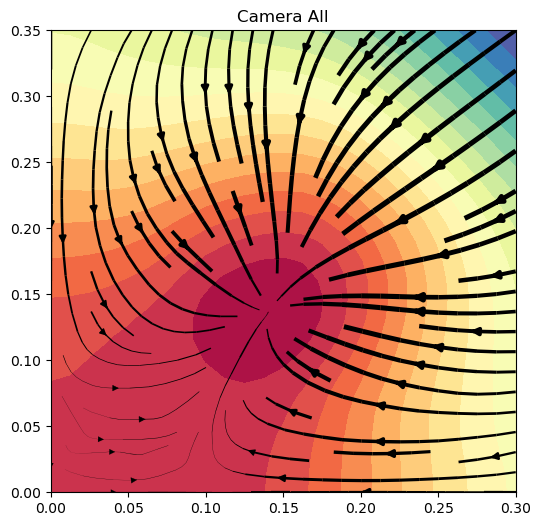

PyObject Text(0.5, 1.0, 'Camera All')

In [29]:
fig, ax = subplots(1,1, figsize=(6,6))

lw = 4 .* cam5_speed ./ maximum(cam5_speed) # Line Widths
ax.contourf(xrange, yrange, cam5_z, cmap="Spectral_r", levels=20)
ax.streamplot(x_coor,y_coor,cam5_zx,cam5_zy, density=0.8,color="k",linewidth=lw)

ax.set_xlim(minimum(xrange), maximum(xrange))
ax.set_ylim(minimum(yrange), maximum(yrange))

ax.set_title("Camera All")

In [30]:
# fig, ax = subplots(1,1, figsize=(6,6))

# lw = 6 .* cam1_speed ./ maximum(cam1_speed) # Line Widths
# ax.contourf(xrange, yrange, cam1_z, cmap="Spectral_r", levels=20)
# ax.streamplot(x_coor,y_coor,cam1_zx,cam1_zy, density=0.8,color="k",linewidth=lw)

# ax.set_xlim(minimum(xrange), maximum(xrange))
# ax.set_ylim(minimum(yrange), maximum(yrange))

# ax.set_title("Camera #1")

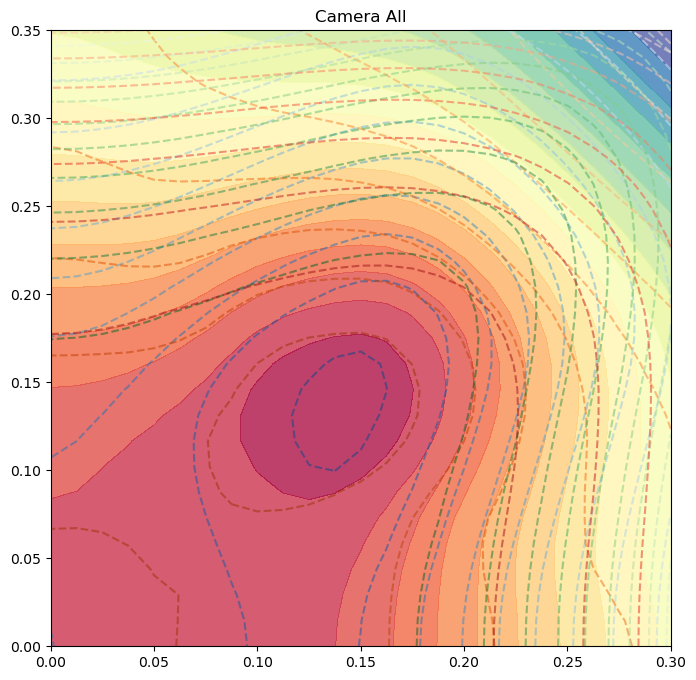

PyObject Text(0.5, 1.0, 'Camera All')

In [65]:
fig, ax = subplots(1,1, figsize=(8,8))

lw = 2 .* cam5_speed ./ maximum(cam5_speed) # Line Widths
ax.contourf(xrange, yrange, cam5_z, cmap="Spectral_r", levels=20, alpha=0.8)
ax.contour(xrange, yrange, cam1_z, cmap="Blues", levels=10, alpha=0.5, linestyles="--")
ax.contour(xrange, yrange, cam2_z, cmap="Oranges", levels=10, alpha=0.5, linestyles="--")
ax.contour(xrange, yrange, cam3_z, cmap="Greens", levels=10, alpha=0.5, linestyles="--")
ax.contour(xrange, yrange, cam4_z, cmap="Reds", levels=10, alpha=0.5, linestyles="--")
# ax.streamplot(x_coor,y_coor,cam5_zx,cam5_zy, density=0.7,color="k",linewidth=lw)

ax.set_xlim(minimum(xrange), maximum(xrange))
ax.set_ylim(minimum(yrange), maximum(yrange))

ax.set_title("Camera All")